# 1a

In [298]:
import numpy as np
import matplotlib.pyplot as plt


Some helper functions.

In [299]:
def generateRandomPoint(width, height):
    '''Helper function to (uniformly) generate a random point within a square of a given width and height.'''
    return (np.random.uniform(0, width), np.random.uniform(0, height))

def generateRandomPointInCircle(R):
    '''Generate a random point within a circle of radius R centered at the origin.'''
    theta = np.random.uniform(0, 2 * np.pi)
    r = R * np.sqrt(np.random.uniform(0, 1))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

def distance(x1, y1, x2, y2):
        '''Gets the (Euclidean) distance between (x1, y1) and (x2, y2).'''
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

Let's make a Tree class to represent the trees in the forest.

In [300]:
class Tree:
    def setOriginDistance(self, d):
        '''
        Sets the distance of self to the origin to d
        
        NB: This doesn't change the position of the Tree!
        '''
        self.origin_dist = d

    '''A Tree in the Sherwood Forest.'''
    def setDiameter(self, D):
        '''Sets diameter of self to D.'''
        self.diameter = D
        
    def setPosition(self, x, y):
        '''Sets position of self to (x,y).'''
        self.x_pos = x
        self.y_pos = y

    def __lt__(self, other):
        '''For sorting purposes. Returns True if self is closer to the origin than other, False otherwise.'''
        return self.origin_dist < other.origin_dist


            

If the forest is big enough, it is impossible to tell whether you are at the center or not just by looking around. This means we can assume that Robin Hood is at the center, so we simply place him at the origin and generate a circular forest around him, making sure not to place trees at the origin.  

In fact, for the sake of realism, let's give Robin some space and say that he is at least one meter from any trees.

In [301]:
# We use the values from Ryden and R=100 as our default values
def generateForest(sigma=0.005, R=100, D=2):
    '''
    Generates a 2d forest of Trees placed randomly in a circle centered on the origin. Also

    Parameters:
    sigma (positive float): The density of the trees pr. unit area
    R (positive float): The radius of the circle within which the forest will be generated
    D (positive float): The diameter of the trees in the forest
    
    Returns a list of Trees.
    '''
    # Calculate area and number of trees to place
    area = np.pi*R**2
    n_Trees = int(sigma*area)

    forest = []

    while len(forest) < n_Trees:
        # Generate a random point in the circle
        x, y = generateRandomPointInCircle(R)

        new_tree = Tree()
        new_tree.setDiameter(D)
        new_tree.setPosition(x, y)
        new_tree.setOriginDistance(distance(x, y, 0, 0))

        # Check if the new Tree touches any existing trees before appending it to the forest
        # We also make sure not to place any trees at the origin
        # all() returns True iff all elements of a list are True
        if all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in forest) and new_tree.origin_dist >= 1:
            forest.append(new_tree)
            # print(f"Placed Tree number {len(forest)} at position ({round(x)}, {round(y)})")

    return forest
        



It would be nice to have a plot of the forest, so let's add that.

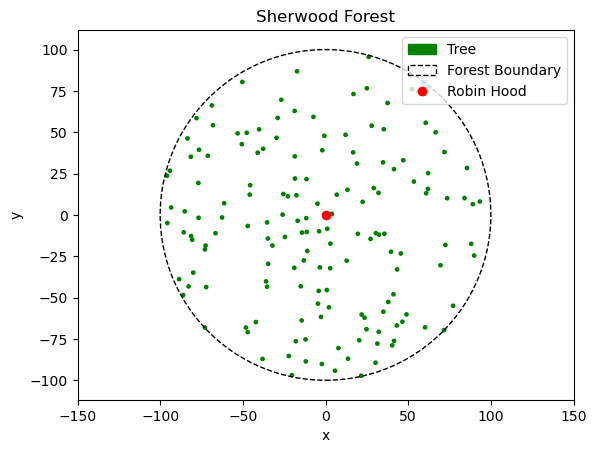

In [316]:
def plotForest(sigma=0.005, R=100, D=2):
    '''
    Plots a forest of Trees.
    
    Takes in the same parameters as generateForest().
    '''
    forest = generateForest(sigma, R, D)
    # Used to avoid setting a label for each Tree
    label_has_been_set = False

    # This adds each tree to the forest
    for tree in forest:
        if label_has_been_set:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color='green', fill=True)
        else:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color='green', fill=True, label='Tree')
            label_has_been_set = True
        plt.gca().add_artist(circle)

    # Draws boundary around the forest    
    circle = plt.Circle((0, 0), R, color='black', fill=False, linestyle='dashed', label='Forest Boundary')
    plt.gca().add_artist(circle)

    # Draws a dot at the origin
    plt.plot(0, 0, 'ro', label='Robin Hood')

    # Makes sure the axes are scaled the same, so the plot doesn't become 'squished'
    plt.axis('equal')
    # Sets appropriate x and y limits to make the whole forest visible
    plt.xlim(-1.5*R, 1.5*R)
    plt.ylim(-1.5*R, 1.5*R)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sherwood Forest')
    plt.legend(loc='upper right')
    plt.show()

plotForest(0.005, 100, 2)

Now we need to implement the shooting of the arrow and check when it hits a tree. We'll use the following formula to get the distance from the center of a tree to the line representing the path of the arrow:  

$\text{dist}(Tree, l) = \dfrac{|a x_0 + b - y_0 |}{\sqrt{a^2 + 1}}$  

Where $x_0, y_0$ is the position of the center of the tree. Obviously, if this distance is less than the radius of the tree, the arrow will hit it.  

We'll run this check on all trees, starting with the ones closest to the origin and moving outward from there. If we need to we can always find ways to optimize this more later.  

Also, as the arrow can only travel in one direction along the line, there will might be trees colliding with the part of the line that is behind the arrow. We'll need to make sure we only check one ''side'' of the line.